# Business Problem 

# Data Cleaning

In [228]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import punkt
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import recall_score, accuracy_score

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob
import gensim
from gensim.models import Word2Vec

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
pd.set_option('display.max_columns', 1000)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
% matplotlib inline

import string, re

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aidancoco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aidancoco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aidancoco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [229]:
data = pd.read_csv('tweets_2.csv')

In [230]:
data.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [231]:
data.isna().sum()

id             0
keyword        0
location    3418
text           0
target         0
dtype: int64

#  Exploratory Data Analysis

## Reclassifying Disaster as Event / Non-Event

In [232]:
data.head(20)

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
5,5,ablaze,OC,"If this child was Chinese, this tweet would ha...",0
6,6,ablaze,"London, England",Several houses have been set ablaze in Ngemsib...,1
7,7,ablaze,Bharat,Asansol: A BJP office in Salanpur village was ...,1
8,8,ablaze,"Accra, Ghana","National Security Minister, Kan Dapaah's side ...",0
9,9,ablaze,Searching,This creature who’s soul is no longer clarent ...,0


When going through the text data, we found that disaster is used incorrectly in classifying the tweets. We found that a better classification would more appropriately be either "Event" or "Non-Event." This is because we found many instances of positive "Disaster" classification when we believe the instance to not meet that definition. For example, many instances of thunderstorms were each classified as a "Disaster", while we believe that instances such as those would be better classified as an "Event."

## What should they search for?

### What's the Class Imbalance?

Text(0, 0.5, 'Percentage')

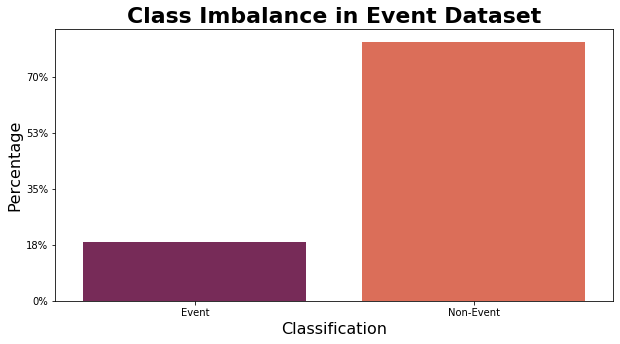

In [233]:
class_imbalance = [len(data[data.target == 1]), len(data[data.target == 0])]
classes = ['Event','Non-Event']

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(classes, class_imbalance, ax = ax, palette='rocket')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(11370))
plt.title('Class Imbalance in Event Dataset', fontsize=22, fontweight='bold')
plt.xlabel('Classification', fontsize=16)
plt.ylabel('Percentage', fontsize=16)

### Most Common Keywords that were Real Events

In [234]:
# data[data.target == 1]['keyword'].value_counts().head(10).plot(kind = 'bar')
keyword_real = pd.DataFrame(data[data.target == 1]['keyword'].value_counts().head(10))
keyword_real.reset_index(inplace=True)
keyword_real.columns = ['keyword','frequency']
keyword_real.keyword = keyword_real.keyword.apply(lambda x: x.split('%20'))
keyword_real.keyword = keyword_real.keyword.apply(lambda x: ','.join(x))
keyword_real.keyword = keyword_real.keyword.apply(lambda x: x.replace(',',' '))
keyword_real.keyword = keyword_real.keyword.apply(lambda x: x.title())


Text(0.5, 0, 'Frequency')

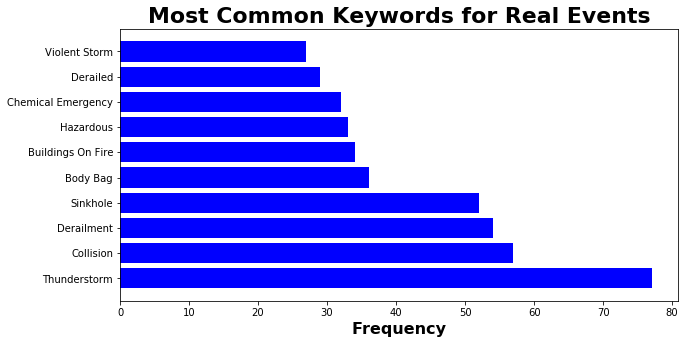

In [235]:
plt.figure(figsize=(10,5))
plt.barh(keyword_real.keyword, keyword_real.frequency, color='blue')
plt.title('Most Common Keywords for Real Events', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=16, fontweight='bold')

### Most Common Keywords that were Not Event Related

In [236]:
keyword_not = pd.DataFrame(data[data.target == 0]['keyword'].value_counts().head(10))
keyword_not.reset_index(inplace=True)
keyword_not.columns = ['keyword','frequency']
keyword_not.keyword = keyword_not.keyword.apply(lambda x: x.split('%20'))
keyword_not.keyword = keyword_not.keyword.apply(lambda x: ','.join(x))
keyword_not.keyword = keyword_not.keyword.apply(lambda x: x.replace(',',' '))
keyword_not.keyword = keyword_not.keyword.apply(lambda x: x.title())

Text(0.5, 0, 'Frequency')

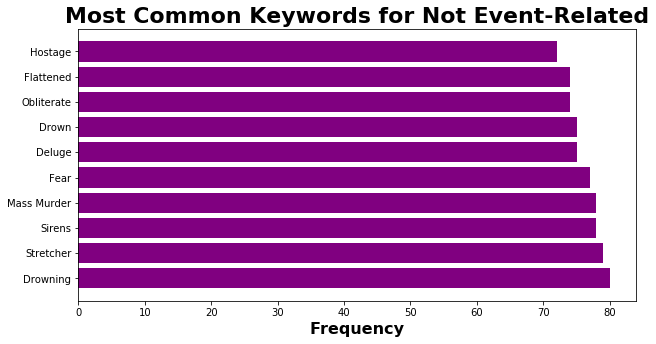

In [237]:
plt.figure(figsize=(10,5))
plt.barh(keyword_not.keyword, keyword_not.frequency, color='purple')
plt.title('Most Common Keywords for Not Event-Related', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=16, fontweight='bold')

### Where are our Tweets Coming From?

In [238]:
data.location.replace(['California, USA', 'Los Angeles, CA', 'United States'], 'USA', inplace= True)
data.location.replace(['Lagos, Nigeria'], 'Nigeria', inplace= True)
data.location.replace(['England, United Kingdom','United Kingdom'], 'UK', inplace= True)
data.location.replace(['Earth'], 'Unknown', inplace= True)


Text(0.5, 0, 'Frequency')

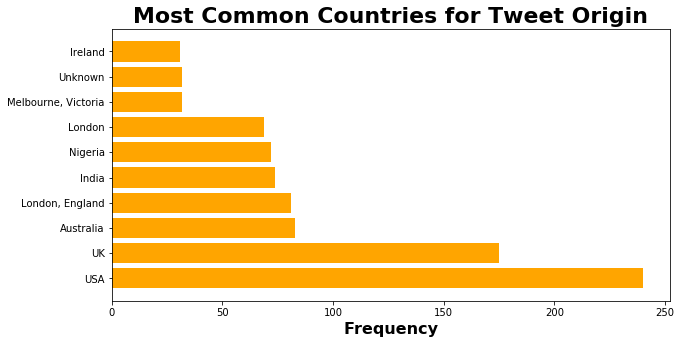

In [239]:
location = pd.DataFrame(data.location.value_counts().head(10))

plt.figure(figsize=(10,5))
plt.barh(location.index, location.location, color='orange')
plt.title('Most Common Countries for Tweet Origin', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=16, fontweight='bold')

### Was Sentiment Different Btw the Positive and Negative Classes?

#### Polarity

In [240]:
data['polarity_score'] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [241]:
positive = data[data.target == 1]
negative = data[data.target == 0]
perc_pos = round((len(positive[positive.polarity_score < 0]) / len(positive)), 3)
perc_neg = round((len(negative[negative.polarity_score < 0]) / len(negative)), 3)
print('{}% of the disaster data has negative polarity'.format(perc_pos))
print('{}% of the non-disaster data has negative polarity'.format(perc_neg))

0.299% of the disaster data has negative polarity
0.225% of the non-disaster data has negative polarity


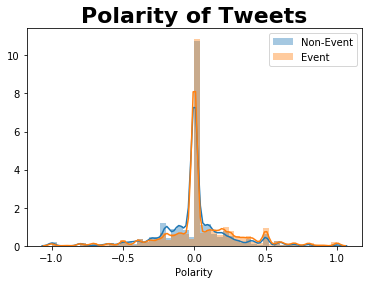

In [242]:
sns.distplot(positive.polarity_score, label='Non-Event')
sns.distplot(negative.polarity_score, label='Event')

plt.title('Polarity of Tweets', fontsize=22, fontweight='bold')
plt.xlabel('Polarity')
plt.legend()

#### Subjectivity

In [243]:
data['subjectivity_score'] = data['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

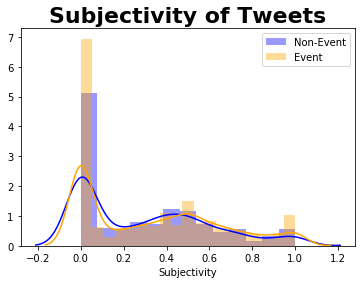

In [244]:
positive = data[data.target == 1]
negative = data[data.target == 0]
sns.distplot(positive.subjectivity_score, label='Non-Event', color='blue')
sns.distplot(negative.subjectivity_score, label='Event', color='orange')

plt.title('Subjectivity of Tweets', fontsize=22, fontweight='bold')
plt.xlabel('Subjectivity')
plt.legend()

### Does Tweet Length Make a Difference?

In [245]:
data['text_length'] = data['text'].apply(lambda x: len(x))

In [246]:
positive = data[data.target == 1]
negative = data[data.target == 0]

Text(0, 0.5, 'Median')

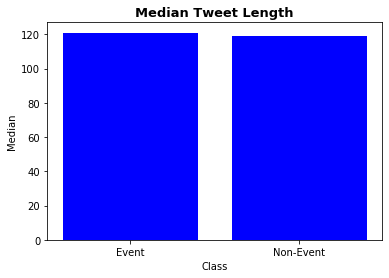

In [247]:
avg_length_pos = positive.text_length.median()
avg_length_neg = negative.text_length.median()
plt.bar(('Event','Non-Event'),(avg_length_pos, avg_length_neg), color='blue')
plt.title('Median Tweet Length', fontsize=13, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Median')

### Is there a Difference Btw Tweets with and without Hyperlinks?

In [248]:
data['hyperlink_present'] = data.text.apply(lambda x: 1 if 'https' in x else 0)

In [249]:
positive = data[data.target == 1]
negative = data[data.target == 0]

Text(0, 0.5, 'Hyperlink in Tweet Rate')

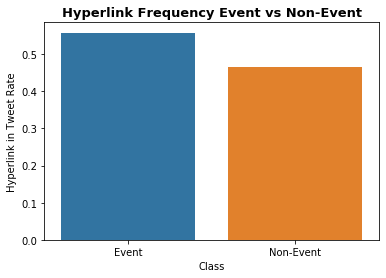

In [250]:
hyperlink_labels = ['Event','Non-Event']
hyperlink_frequencies = ((positive.hyperlink_present.sum() / len(positive)), 
                     (negative.hyperlink_present.sum() / len(negative)))

sns.barplot(hyperlink_labels, hyperlink_frequencies)
plt.title('Hyperlink Frequency Event vs Non-Event', fontsize=13, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Hyperlink in Tweet Rate')

### Most Common Unigram Search Result Words for Real Events

In [251]:
cloud = data
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
cloud.text = cloud.text.apply(lambda x: tokenizer.tokenize(x))

In [252]:
def lower_token(word_list):
    lowered_tokenized = []
    for x in word_list:
        x = x.lower()
        lowered_tokenized.append(x)
    return lowered_tokenized

cloud.text = cloud.text.apply(lambda x: lower_token(x))

In [253]:
stopword_given = stopwords.words('english')
more_stopwords = ['co','amp','say','want','really','many','let','see','said','got','day','https','c','w','still','go','u','new','one','b','know','two','make','people','us','think','h','time','g','another','p','l','today','th','n','e','v','x','j','z','f','always','good','thing','must','someone','even','much','guy','work','house','video','every','stop','remember','need','first','back','country','well','man','come','live','year','via','take','going','tell','next','q','place','says','days','made','news','world','hour','feel','bad','last','never','put','may','way','gon','na','au','gove']
stopwords_final = stopword_given + more_stopwords

In [254]:
def remove_stops(word_list):
    filtered = []
    for x in word_list:
        if x not in stopwords_final:
            filtered.append(x)
    return filtered

cloud.text = cloud.text.apply(lambda x: remove_stops(x))

In [255]:
cloud.text = cloud.text.apply(lambda x: ','.join(x))
cloud.text = cloud.text.apply(lambda x: x.replace(',',' '))

In [256]:
cloud_positive = cloud[cloud.target == 1]
text_positive = " ".join(review for review in cloud_positive.text)

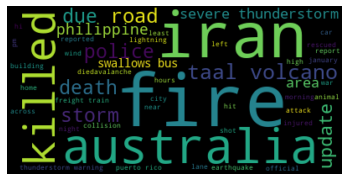

In [257]:
wordcloud_full = WordCloud(background_color="black", max_words = 50).generate(text_positive)

plt.imshow(wordcloud_full, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most Common Unigram Search Result Words for Non Event-Related

In [258]:
cloud_negative = cloud[cloud.target == 0]

In [259]:
text_negative = " ".join(review for review in cloud_negative.text)

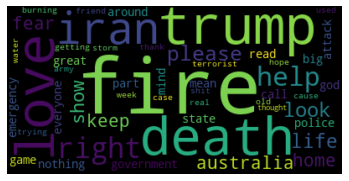

In [260]:
wordcloud_negative = WordCloud(background_color="black", max_words = 50).generate(text_negative)

plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most Common Unigram Search Result Words for Real Events

In [261]:
def wordcloud_creator_bigram(data, max_words = 50, stopwords=None):

    # Tokenize data
    nltk_tokens = nltk.word_tokenize(data)
    tokens_minus_stop = []
    for i in nltk_tokens:
        if i not in stopwords_final:
            tokens_minus_stop.append(i)
    # Create bigrams
    bigrams_list = list(nltk.bigrams(tokens_minus_stop))
    # Join bigrams
    bigrams = [' '.join(tup) for tup in bigrams_list]
    # Fit transform bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(bigrams)
    # Get bigram counts
    sum_words = bag_of_words.sum(axis=0) 
    # Create fequency dictionary
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    # Sort frequency dictionary
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # Reformat as dictionary
    words_dict = dict(words_freq)
    
    # Create wordcloud
    wordcloud = WordCloud(max_words=max_words, stopwords=None)
    wordcloud.generate_from_frequencies(words_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
    return plt.show()

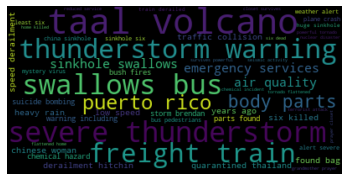

In [262]:
wordcloud_creator_bigram(text_positive)

### Most Common Bigram Search Result Words for Non Event-Related

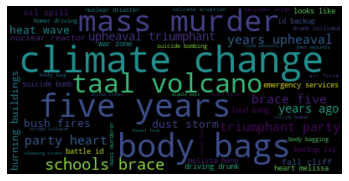

In [263]:
wordcloud_creator_bigram(text_negative)

### Most Similar Words for Real Event

In [264]:
vec_positive = data[data.target == 1]

In [265]:
tokenizer_vec_positive = RegexpTokenizer(r'[a-zA-Z]+')

vec_positive.text = vec_positive.text.apply(lambda x: tokenizer_vec_positive.tokenize(x))



In [266]:
vec_positive.text = vec_positive.text.apply(lambda x: remove_stops(x))

In [267]:
vec_positive_list = []

for sentence in vec_positive.text:
    vec_positive_list.append(sentence)

In [268]:
model_positive = gensim.models.Word2Vec(vec_positive_list, size=32)

In [269]:
model_positive.most_similar('ablaze')

[('avalanche', 0.8849360942840576),
 ('fire', 0.879629909992218),
 ('homes', 0.8720437288284302),
 ('killed', 0.8696730136871338),
 ('affect', 0.8696595430374146),
 ('ash', 0.8670036196708679),
 ('dead', 0.8667020797729492),
 ('earthquake', 0.8664407730102539),
 ('suicide', 0.8664273023605347),
 ('died', 0.8661086559295654)]

### Most Similar Words for Non Event-Related

In [270]:
vec_negative = data[data.target == 0]

In [271]:
tokenizer_vec_negative = RegexpTokenizer(r'[a-zA-Z]+')

vec_negative.text = vec_negative.text.apply(lambda x: tokenizer_vec_negative.tokenize(x))


In [272]:
vec_negative.text = vec_negative.text.apply(lambda x: remove_stops(x))


In [273]:
vec_negative_list = []

for sentence in vec_negative.text:
    vec_negative_list.append(sentence)

In [274]:
model_negative = gensim.models.Word2Vec(vec_negative_list, size=32)

In [275]:
model_negative.most_similar('ablaze')

[('prevent', 0.9646755456924438),
 ('miss', 0.9645379781723022),
 ('reminder', 0.9642804861068726),
 ('rioting', 0.9638572335243225),
 ('fa', 0.9638320207595825),
 ('major', 0.9637085199356079),
 ('job', 0.9624791145324707),
 ('crush', 0.9621676802635193),
 ('king', 0.9613732099533081),
 ('network', 0.9613556861877441)]

# Feature engineering

### Lemmitization

In [456]:
data_model = pd.read_csv('tweets_2.csv')

In [457]:
data_model.text

0        Communal violence in Bhainsa, Telangana. "Ston...
1        Telangana: Section 144 has been imposed in Bha...
2        Arsonist sets cars ablaze at dealership https:...
3        Arsonist sets cars ablaze at dealership https:...
4        "Lord Jesus, your love brings freedom and pard...
                               ...                        
11365    Media should have warned us well in advance. T...
11366    i feel directly attacked 💀 i consider moonbin ...
11367    i feel directly attacked 💀 i consider moonbin ...
11368    ok who remember "outcast" nd the "dora" au?? T...
11369       Jake Corway wrecked while running 14th at IRP.
Name: text, Length: 11370, dtype: object

In [458]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9!]+')

data_model.text = data_model.text.apply(lambda x: tokenizer.tokenize(x))

In [459]:
lemmatizer = WordNetLemmatizer() 

def lemm_text(words):
    lem = []
    for word in words:
        lem.append(lemmatizer.lemmatize(word))
    return lem  

In [460]:
data_model.text = data_model.text.apply(lambda x: lemm_text(x))

In [461]:
# Reformat to singular strings per observation
data_model.text = data_model.text.apply(lambda x: ','.join(x))
data_model.text = data_model.text.apply(lambda x: x.replace(',',' '))

###  Calculating TDIDF scores

In [462]:
X = data_model.text
Y = data_model.target
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [463]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'said', 'one', 'com', 'http', '-', '–', '—', 'co', 'wa', 'ha', '1', 'amp']
sw_set = set(sw_list)

In [464]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X, Y, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer(ngram_range= (1,2), stop_words= sw_set)

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)


# Modeling 

Our data has a significant class imbalance, so just guessing that each case was a non event would be accurate 80% of the time. We need to find a model that can do significantly better than 80% accuracy and demonstrate through F1 score that is able to do a good job of distingusing between the two classes. 

### Baseline KNN

In [465]:
knn = KNeighborsClassifier(n_neighbors=1)

In [466]:
bl_model = knn.fit(tfidf_data_train_lem, y_train_lem)

In [467]:
bl_pred = bl_model.predict(tfidf_data_test_lem)

In [468]:
rf_acc_score_lem = accuracy_score(y_test_lem, bl_pred)
rf_f1_score_lem = f1_score(y_test_lem, bl_pred)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.8773

F1 Score: 0.5044


An out of the box knn is 87% accurate and does an okay job of picking between the two classes. I think more advanced models will work better however.

## Random Forest Classifier with TFIDF Scores

First lets try a Random Forest Classifier (RFC) with TFIDF scores

In [469]:
from sklearn.metrics import f1_score

In [470]:
rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=0, class_weight= 'balanced')

In [471]:
rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)

rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [472]:
rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.8896

F1 Score: 0.5851


An RCF classifier did significantly better than our baseline, bumping the accuracy up to .889 and achieving and F1 score of .581. Lets still check if a Naive Bayes Classifier does any better then tune whichecver one works the best. 

## Naive Bayes

Lets try a Naive Bayes model with our TDIF scores and see if we can get some better results.

In [478]:
from sklearn.naive_bayes import MultinomialNB

In [510]:
nb_classifier = MultinomialNB(alpha = .01)

In [511]:
nb_classifier.fit(tfidf_data_train_lem, y_train_lem)
nb_test_preds_lem = nb_classifier.predict(tfidf_data_test_lem)


In [481]:
nb_acc_score_lem = accuracy_score(y_test_lem, nb_test_preds_lem)
nb_f1_score_lem = f1_score(y_test_lem, nb_test_preds_lem)

In [482]:
print('Naive Bayes with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(nb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(nb_f1_score_lem))

Naive Bayes with Lemmatization Features
Testing Accuracy: 0.8971

F1 Score: 0.6803


The NB classifier did great! It got our accuracy up to .9 and with an F1 score of .68 it is pretty good at differntiating between the two classes. 

### Hyperparameter Tuning

In [514]:
from sklearn.model_selection import GridSearchCV
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0 ], 'fit_prior' : [True, False]
         }

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, scoring= 'f1', verbose=5)

multinomial_nb_grid.fit(tfidf_data_train_lem, y_train_lem)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.9s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0],
                         'fit_prior': [True, False]},
             scoring='f1', verbose=5)

In [515]:
multinomial_nb_grid.best_params_

{'alpha': 1.0, 'fit_prior': False}

In [516]:
grid_preds = multinomial_nb_grid.predict(tfidf_data_test_lem)

In [517]:
nb_acc_score_lem = accuracy_score(y_test_lem, grid_preds)
nb_f1_score_lem = f1_score(y_test_lem, grid_preds)

In [518]:
print('Naive Bayes with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(nb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(nb_f1_score_lem))

Naive Bayes with Lemmatization Features
Testing Accuracy: 0.8923

F1 Score: 0.6166


### Additional Cross Validation 

I am not sure why the non grid search model seemed to perform far better, lets try some further cross validation to see if it can help us understand whats happening here. 

In [499]:
nb_best = MultinomialNB(alpha = 1)

In [490]:
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator= nb_classifier, X= tfidf_data_train_lem, y= y_train_lem, cv=5)

In [491]:
all_accuracies

array([0.61373626, 0.61847169, 0.62231996, 0.64046179, 0.62616822])

In [503]:
from sklearn.model_selection import cross_val_score
all_accuracies_best = cross_val_score(estimator= nb_best, X= tfidf_data_train_lem, y= y_train_lem, cv=5)

In [504]:
all_accuracies

array([0.61373626, 0.61847169, 0.62231996, 0.64046179, 0.62616822])

### Most Important Features 

In [513]:
feature_names = tfidf.get_feature_names()
top10 = np.argsort(nb_classifier.coef_[0])[-10:]

print(" ".join(feature_names[j] for j in top10))

sinkhole china storm volcano thunderstorm iran killed train people fire


**The most words in the Multinomial Naive Bayes Classifier model are:** 
1. sinkhole 
2. china 
3. storm 
4. volcano 
5. thunderstorm 
6. iran 
7. killed 
8. train 
9. people 
10. fire

## Further Validation

We downloaded 100 tweets using the same key terms as the original dataset. We manually tagged them as an even or non event using the same methodology as our original data set. Lets see how our model does on totally different tweets from our train and test set!

# Analysis and Application

## How did our models do?

Our best model was the multinomial naive bayes classifier which got a cross validated F1 score around .61 and an accuracy score consistently over .88. This means that our model was 8% more accurate than guessing the dominant class and had a reasonable ability to distinguish between the two classes. From this we can say it would be a useful model to further narrow your search when trying to determine between events and non events, but not the end of the process. 

## Reccomendations

## Next Steps